In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft
import pylab as pl
import warnings
warnings.filterwarnings('ignore')
import random

In [ ]:
from google.colab import files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
plt.rcParams["figure.figsize"] = (16,8) # 10, 5

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# data_puzzle.dat:
# https://drive.google.com/open?id=1emQxtwN4DXTgeup-DUufjAJ1QZmyuTXh
filename = 'data_puzzle.dat'
id = '1emQxtwN4DXTgeup-DUufjAJ1QZmyuTXh'
drive.CreateFile({'id': id}).GetContentFile(filename)
data = pd.read_csv(filename, header=None, sep=',', error_bad_lines=False)

In [ ]:
# !pip install -i https://test.pypi.org/simple/ MFDFA
from MFDFA import MFDFA
from MFDFA import fgn

In [ ]:
# np.random.seed(111111)
np.random.seed(11111)

# <center> Fractional gaussian noise </center>

In [ ]:
t_final = 500
delta_t = 0.001

# # Some drift theta and diffusion sigma parameters
# theta = 0.3
# sigma = 0.1

# The time array of the trajectory
time = np.arange(0, t_final, delta_t)

# The fractional Gaussian noise
H = 0.7
gaussian_noise = (t_final ** H) * fgn(N = time.size, H = H)

# # Initialise the array y
# y = np.zeros([time.size])

# # Integrate the process
# for i in range(1, time.size):
#     y[i] = y[i-1] - theta * y[i-1] * delta_t + sigma * dB[i]

# <center> MFDFA in log-log scale<br> Hurst exponent </center>

In [ ]:
def do_mfdfa(y, q_list, start_index, end_index):
  window_sizes = np.logspace(0.7, 4, 50).astype(int)
  # 50 elements ranging from 1e+0.7 to 1e+4
  # An array with the window sizes to calculate (ints)

  order = 1 # order of polynomial to fit

  q_slopes = [] # Hurst exponents list
  # q_list = [-10, -9, -8, -7, -6, -5, -4, -3, -2, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

  for q in q_list:
    
    lag, dfa = MFDFA(y, lag=window_sizes, q = q, order = order)
    plt.loglog(lag, dfa, '-', linewidth = 0.5)
    xs = np.array(np.log(lag), dtype=np.float64)
    ys = np.array(np.log(dfa), dtype=np.float64)
    # slope = best_fit_slope(xs, abs(ys))
    slope = np.polyfit(xs[start_index:end_index], ys[start_index:end_index], 1,)[0][0]
    q_slopes.append(slope)

  labels= ["MFDFA in log-log scale"]
  plt.legend(labels)
  plt.xlabel("s (window size)")
  plt.ylabel("F_q(s) (dfa)")
  # plt.text(1e+2, 1e+1, 'q>0', color='red', fontdict={'fontsize': 20})
  # plt.text(0.5e+3, 1e-2, 'q<0', color='red', fontdict={'fontsize': 20})
  plt.show()
  return q_slopes

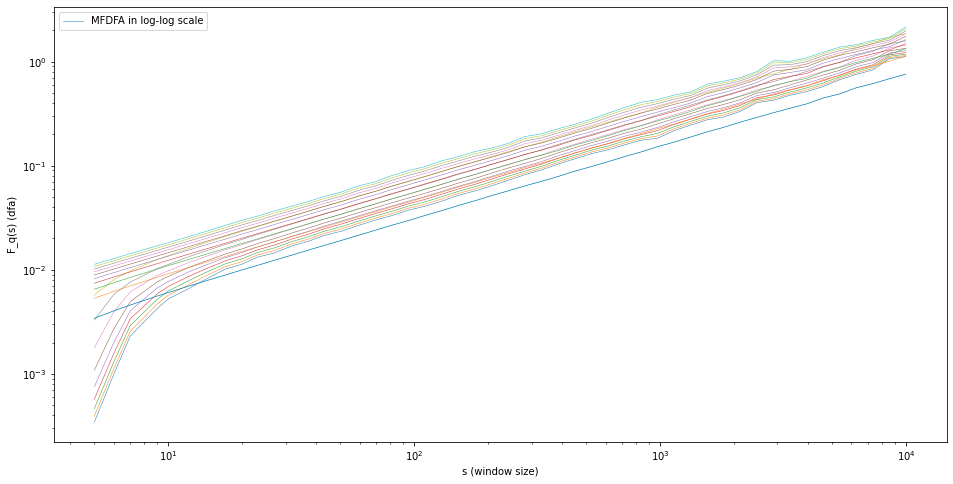

In [ ]:
q_list = [-10, -9, -8, -7, -6, -5, -4, -3, -2, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
q_slopes = do_mfdfa(gaussian_noise, q_list, 10, 40)

# <center> Multifractal spectrum </center>

In [ ]:
def deriv(q, tau, i):
  return ((tau[i+1] - tau[i]) / (q[i+1] - q[i]))

In [ ]:
def get_qs_and_hqs(q_list, q_slopes):
  qs = []
  hqs = []
  for i in range(len(q_list)):
    if np.isnan(q_slopes)[i] == False:
      qs.append(q_list[i])
      hqs.append(q_slopes[i])
  return qs, hqs

In [ ]:
def mfs(q_list, q_slopes):
  qs, hqs = get_qs_and_hqs(q_list, q_slopes)
  print(qs, hqs)

  # --------- q and h(q) ---------
  plt.plot(qs,hqs)
  labels= ["Multifractal spectrum"]
  plt.legend(labels)
  plt.xlabel("q")
  plt.ylabel("h(q)")
  plt.show()

  # --------- q and tau(q) ---------

  tau = [a*b for a,b in zip(qs,hqs)]
  tau = [x-1 for x in tau]
  diff = np.max(tau) - np.min(tau)
  plt.ylim(np.min(tau)-0.1*diff, np.max(tau)+0.1*diff)
  plt.plot(qs, tau)
  labels= ["Multifractal spectrum"]
  plt.legend(labels)
  plt.xlabel("q")
  plt.ylabel("\u03C4(q)")
  plt.show()

 # --------- alpha and f(alpha) ---------

  alphas = []
  for i in range(len(qs)-1):
    alphas.append(deriv(qs, tau, i))
  
  # alpha and f(alpha) arrays
  tmp = [x*y for x,y in zip(qs,alphas)]
  f_alphas = [x - y for x,y in zip(tmp,tau)]
  alphas_sorted = [x for x,_ in sorted(zip(alphas,f_alphas))]
  f_alphas_sorted = [x for _,x in sorted(zip(alphas,f_alphas))]

  plt.plot(alphas_sorted, f_alphas_sorted, marker = 'o')
  labels= ["Multifractal spectrum"]
  plt.legend(labels)
  plt.xlabel(u'\u03B1')
  plt.ylabel('f(' + u'\u03B1' + ')')
  plt.show()

[-10, -9, -8, -7, -6, -5, -4, -3, -2, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [0.7143105116799038, 0.712025729056156, 0.7099765888755438, 0.7082040573575509, 0.7067113183502493, 0.7054613025842545, 0.7043857126031244, 0.7034000963139847, 0.7024192595173376, 0.6988825702470286, 0.6988825702470286, 0.69742091982666, 0.695845433393934, 0.6942052695179147, 0.692549370863629, 0.6909053713415331, 0.6892702706060205, 0.6876200937768793, 0.6859297295760342, 0.6841876823275056]


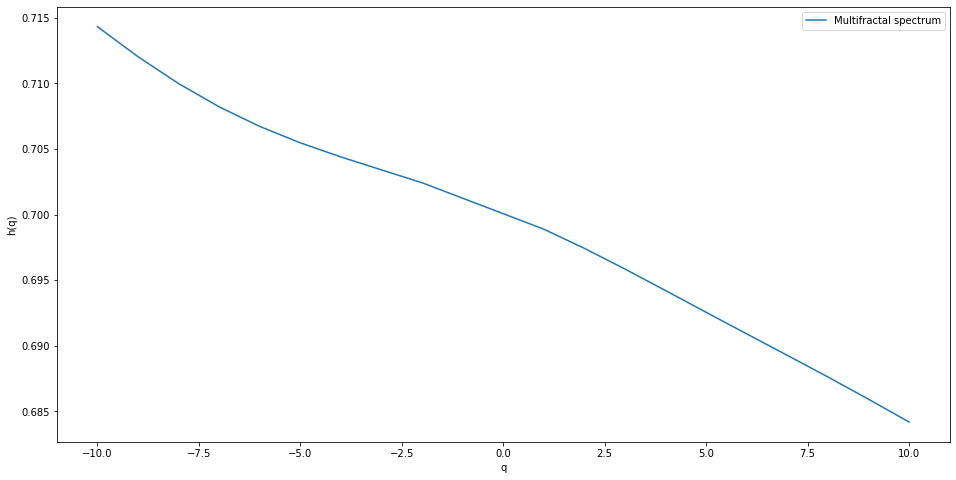

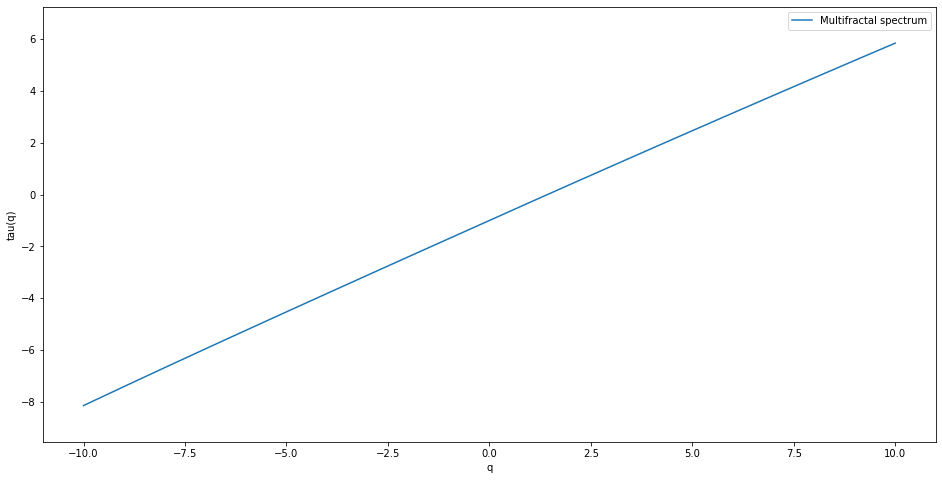

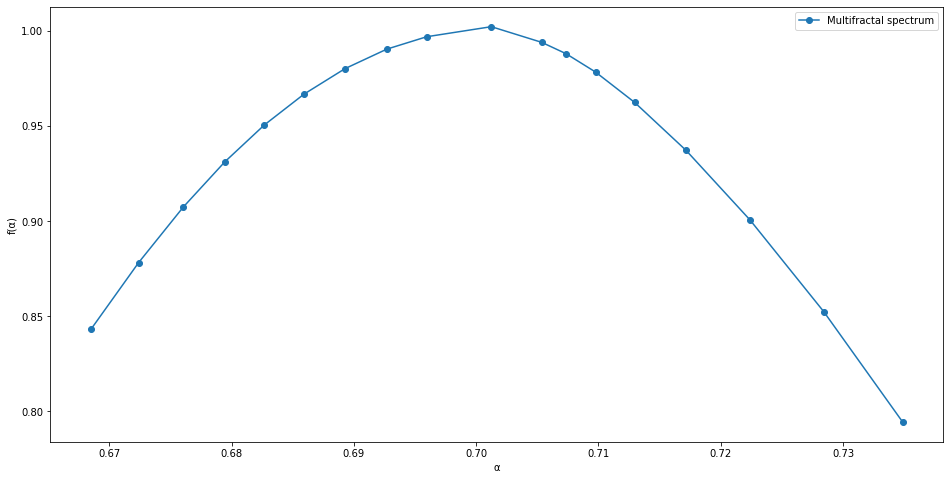

In [ ]:
mfs(q_list, q_slopes)

# <center> MFDFA and multifractal spectrum with Gaussian noise (for comparsion) </center>

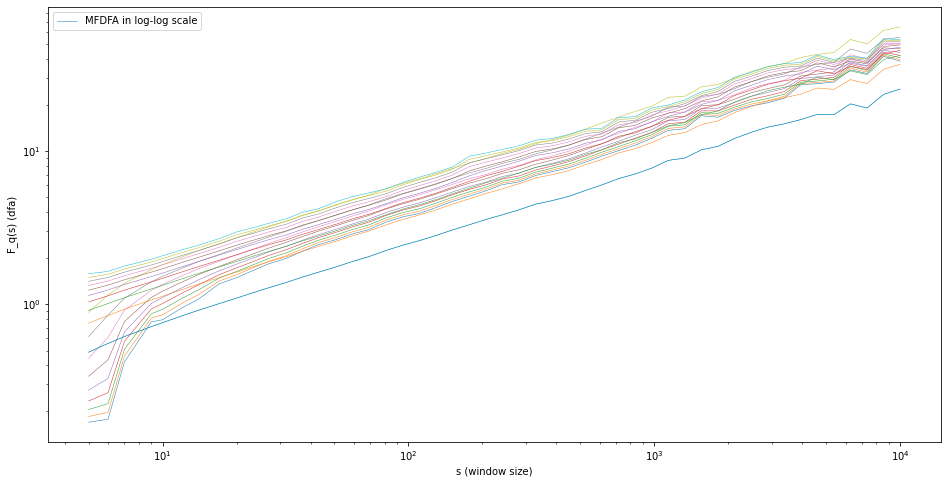

[-10, -9, -8, -7, -6, -5, -4, -3, -2, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [0.522373013669967, 0.5194369454160529, 0.5166843134313946, 0.514196905712114, 0.5120416217036656, 0.5102597366637314, 0.5088590555918131, 0.5078086190166714, 0.507034460936297, 0.5050440739083921, 0.5050440739083921, 0.5039817568685817, 0.5025188559824532, 0.500598086064199, 0.4982075197519711, 0.49537729742890807, 0.4921743368251801, 0.4886933363315338, 0.4850434641015877, 0.4813329763658203]


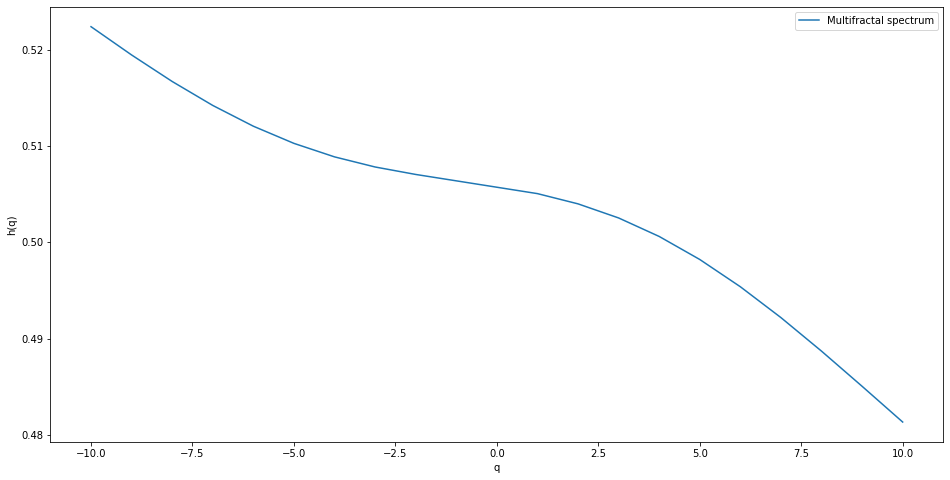

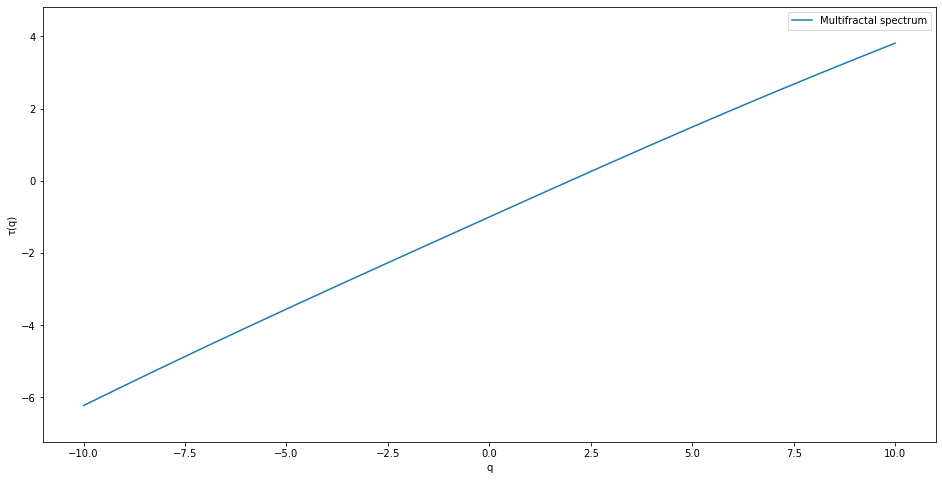

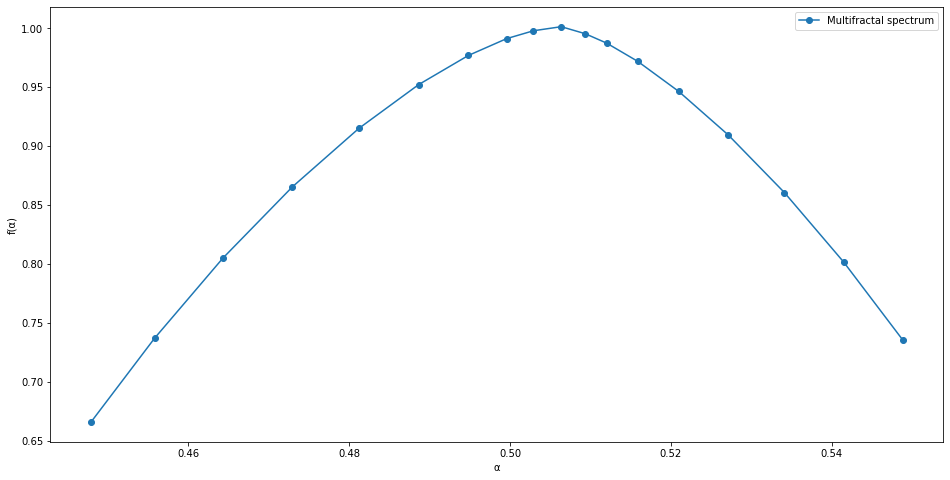

In [ ]:
np.random.seed(111111)
 # Gaussian noise - same as setting H = 0.5 in the first noise generator
gaussian_noise = np.random.normal(loc=0, scale=1, size=50000)
q_list = [-10, -9, -8, -7, -6, -5, -4, -3, -2, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
q_slopes = do_mfdfa(gaussian_noise, q_list, 10, 40)
mfs(q_list, q_slopes)